In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            classification_report,
                            plot_confusion_matrix,
                            plot_roc_curve)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt 

# importing scaler 
from sklearn.preprocessing import StandardScaler

# import vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

import time 

## Getting data

In [3]:
# reading in data and making sure it looks good 

# country_rock = pd.read_csv('../datasets/country_rock.csv')
# country_rock.head()

In [4]:
country_rock = pd.read_pickle('../datasets/country_rock.pkl')
country_rock.head()

,label,merged,tokens
0,0,country suggestions ve been starting to get in...,"[country, suggestions, ve, been, starting, to,..."
1,0,hank williams sr m so lonesome could cry (1949),"[hank, williams, sr, m, so, lonesome, could, c..."
2,0,cody jinks loud and heavy,"[cody, jinks, loud, and, heavy]"
3,0,"southern raised performs ""what day that will b...","[southern, raised, performs, what, day, that, ..."
4,0,is anybody still making texas swing? my father...,"[is, anybody, still, making, texas, swing, my,..."


In [5]:
country_rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   6000 non-null   int64 
 1   merged  6000 non-null   object
 2   tokens  6000 non-null   object
dtypes: int64(1), object(2)
memory usage: 140.8+ KB


In [6]:
country_rock.shape

(6000, 3)

In [7]:
# identifying X and y 
X = country_rock['merged']
y = country_rock['label']
    
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                               y, 
                                               test_size=0.25,
                                               shuffle=True,
                                               stratify=y,
                                               random_state=42)

# checking class balance 
print(f'Value counts: \n{y.value_counts(normalize=True)}')

Value counts: 
1    0.5
0    0.5
Name: label, dtype: float64


## Models 

In the "05-Model_Benchmarking" notebook in this folder, I performed grid searches on the following models: 

I selected _______ models to build my final analysis and evaluation primariliy because they were the most accurate least underfit, as well as being interpretable for my audience. I used hyperparameters based on what the results of the grid search `grid.best_params_` method for each of these modeling techniques and vectorizers. 

In [8]:
country_rock_stop_words = ['country', 'countries', 'rock', 'roll', 'just','song', 'songs', 'music', 
                           'album', 'band', 'bands', 'artist', 'artists', 've', 'don']
all_stop_words = text.ENGLISH_STOP_WORDS.union(country_rock_stop_words)

#### `Baseline Model`

In [9]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

The result of the `value_counts` in the above cell indicates that the accuracy of our baseline model would be 50%, i.e. that if we were to predict that all of the posts are from the country music subreddit, we would be right 50% of the time. Let's hope our other models will perform better! 

# explain why I chose logistic regression 

#### `Logistic Regression`

In [10]:
# Logistic Regression pipe in two stages 

pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=all_stop_words, max_features=5000, ngram_range=(1,2))),
    ('lr', LogisticRegression(C=1, penalty='l2', solver='newton-cg'))
])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'album',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'a

In [11]:
print(f'Training set accuracy on Logistic Regression model with Tf-Idf vectorizer = {pipe_lr.score(X_train, y_train)}')
print(f'Testing set accuracy on Logistic Regression model with Tf-Idf vectorizer = {pipe_lr.score(X_test, y_test)}')

Training set accuracy on Logistic Regression model with Tf-Idf vectorizer = 0.924
Testing set accuracy on Logistic Regression model with Tf-Idf vectorizer = 0.822


In [12]:
cross_val_score(pipe_lr, X_train, y_train, cv=3).mean()

0.7942222222222223

In [13]:
pipe_lr.score(X_train, y_train)

0.924

In [14]:
pipe_lr.score(X_test, y_test)

0.822

## Evalution

## Finding and Plotting Most Important Words 

#### `Logistic Regression Model` Word Importances

In [15]:
# vectorizing data just to create bag of words 

# tfidf = TfidfVectorizer()

# tfidf.fit(X_train)

In [16]:
def find_most_important_words(vectorizer, estimator, n=10):
    
    index_to_word = {v:k for k, v in vectorizer.vocabulary_.items()}
    
#     most_important = {}

    # get coefficient for each word in the vocabulary 
    word_importances = [(el, index_to_word[i]) for i, el in enumerate(np.exp(estimator.coef_[0]))]  
    
    # sort the word_imoprtance coefficients by the coefficient 
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)   

    # find words most important to label 1 by sorting by the highest coefficient
    closest_to_label_1 = sorted(sorted_coeff[:n], key = lambda x : x[0])
    
    # find words most important to label 0 by sorting by the smallest coefficient
    closest_to_label_0 = sorted_coeff[-n:]
    
    return closest_to_label_0, closest_to_label_1

In [17]:
pipe_lr.named_steps['lr']

LogisticRegression(C=1, solver='newton-cg')

_Citation: Thank you Prasoon Karmacharya for helping me figure out the `.name_steps` method so that I could feed my `pipeline` into my `find_most_important_words` function!_ 

In [29]:
closest_to_label_0, closest_to_label_1 = find_most_important_words(pipe_lr.named_steps['tfidf'], pipe_lr.named_steps['lr'], n=100)

In [30]:
closest_to_label_0[-10::]

[(0.17397633511738658, 'dolly'),
 (0.17279492234927613, 'old'),
 (0.1657896528834616, 'charlie'),
 (0.1554655588447922, 'cash'),
 (0.15377834416277517, 'merle'),
 (0.15100617591873858, 'jones'),
 (0.13790389242266957, 'willie'),
 (0.12464944814758712, 'hank'),
 (0.11701627778179775, 'johnny'),
 (0.11036392685060976, 'cowboy')]

In [51]:
country_df = pd.DataFrame(closest_to_label_0).sort_values(0, ascending=False)

country_df.reindex(index=country_df.index[::-1])

,0,1
99,0.110364,cowboy
98,0.117016,johnny
97,0.124649,hank
96,0.137904,willie
95,0.151006,jones
...,...,...
4,0.359160,google
3,0.360601,dad
2,0.364458,lawrence
1,0.364909,colter wall


In [52]:
closest_to_label_1[-10::]

[(5.030629292149185, 'review'),
 (5.092273887766607, 'removed'),
 (5.3770786950949825, '2016'),
 (5.60750549786692, '2003'),
 (5.623767786439253, 'interview'),
 (5.8761731382845035, 'hard'),
 (6.355103723655234, 'tool'),
 (6.956855183999518, '2020'),
 (8.79681858217044, 'punk'),
 (9.381079951919261, 'metal')]

In [65]:
rock_df = pd.DataFrame(closest_to_label_1).sort_values(0, ascending=True)
rock_df.sort_index()
# rock_df.reindex(index=country_df.index[::-1])

,0,1
0,2.330921,christian
1,2.330921,christian reeve
2,2.330921,reeve
3,2.343334,talks
4,2.347516,club
...,...,...
95,5.876173,hard
96,6.355104,tool
97,6.956855,2020
98,8.796819,punk


## Visualizations 

In [54]:
font = {'family': 'serif',
        'color':  '#1a1b1e',
        'weight': 'normal',
        'size': 20,
        }

def plot_most_important_words(scores_0, words_0, scores_1, words_1, title):
    
    y_pos = np.arange(len(words_1))
    
    pairs_1 = [(a,b) for a,b in zip(words_1, scores_1)]
    pairs_1 = sorted(pairs_1, key=lambda x: x[1])
    
    pairs_0 = [(a,b) for a,b in zip(words_0, scores_0)]
    pairs_0 = sorted(pairs_0, key=lambda x: x[1])
    
    words_1 = [a[0] for a in pairs_1]
    scores_1 = [a[1] for a in pairs_1]
    
    words_0 = [a[0] for a in pairs_0]
    scores_0 = [a[1] for a in pairs_0]
    
    fig = plt.figure(figsize=(12, 12))
    
    plt.subplot(121)
    plt.barh(y_pos, scores_0, align='center', alpha=0.5, color='#1a1b1e')
    plt.title('Country Western', fontdict=font)
    plt.yticks(y_pos, words_0, fontsize=14)
#     plt.suptitle('Key Words', fontsize=16)
    plt.xlabel('Importance', fontdict=font)
    
    plt.subplot(122)
    plt.barh(y_pos, scores_1, align='center', alpha=0.5, color="#f24600")
    plt.title("Rock 'n' Roll", fontdict=font)
    plt.yticks(y_pos, words_1, fontsize=15)
#     plt.suptitle('Key Words', fontsize=16)
    plt.xlabel('Importance', fontdict=font)
    
    plt.subplots_adjust(wspace=.4)

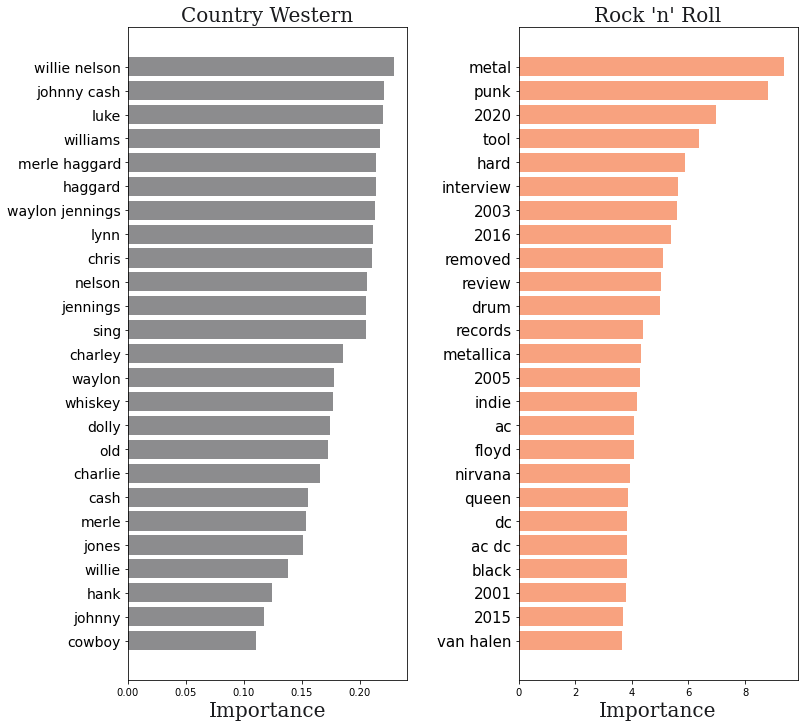

In [66]:
# getting most important words from get_important_words 

label_0_scores = [x[0] for x in closest_to_label_0[-25::]]
label_0_words = [x[1] for x in closest_to_label_0[-25::]]
label_1_scores = [x[0] for x in closest_to_label_1[-25::]]
label_1_words = [x[1] for x in closest_to_label_1[-25::]]

plot_most_important_words(label_0_scores, label_0_words, label_1_scores, label_1_words, 'title')

In [ ]:
# saving this figure so that I can put it in my README 

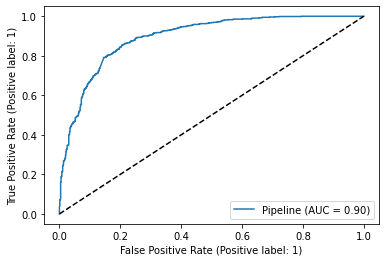

In [310]:
# ROC curve 

plot_roc_curve(pipe_lr, X_test, y_test)
plt.plot([0,1], [0,1], 'k--');

In [305]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

#brings to two dimenstions 

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['#1a1b1e','#f24600']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='#1a1b1e', label='Country')
            green_patch = mpatches.Patch(color='#f24600', label='Rock')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


# fig = plt.figure(figsize=(16, 16))          
# plot_LSA(X_train_counts, y_train)
# plt.show()

In [306]:
# cvec = CountVectorizer(stop_words=all_stop_words)

# X_train_cvec = cvec.fit_transform(X_train)

# fig = plt.figure(figsize=(8,8))          
# plot_LSA(X_train_cvec, y_train)
# plt.show()

In [308]:
import sys 
sys.getsizeof(X_train_tfidf)

48

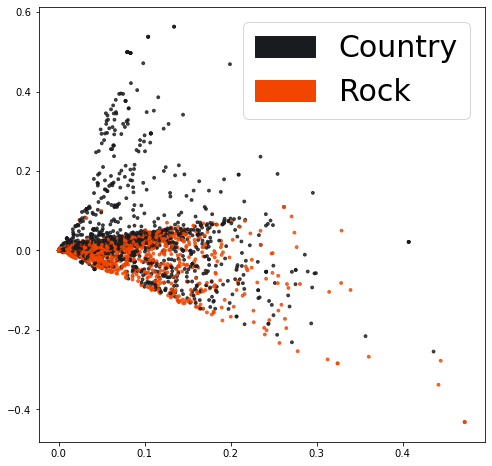

In [307]:
tfidf = TfidfVectorizer(stop_words=all_stop_words)

X_train_tfidf = tfidf.fit_transform(X_train)

fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_tfidf, y_train)
plt.show()